## Previsão de mercado automotivo do Brasil

<div class="alert alert-block alert-warning">
<b>Sobre o conteúdo:</b> Este é um projeto pessoal do estudo previsões de séries temporais (registros de informações que ocorrem ao longo do tempo). <br>
<b>Objetivo:</b> Realizar previsão de emplacamentos mensais de veículos no mercado automotivo brasileiro.<br>
<br>Fonte: séries históricas Anfavea
</div>

### Etapas do projeto

>1) Importar bibliotecas necessárias para o projeto. <br>
>2) Importar dados para a análise: arquivo excel com emplacamentos mensais obtidos no site da Anfavea <br>
>3) Análise exploratória dos dados  <br>
>4) Preparação dos dados para carregar no modelo.
>5) Treino do modelo preditivo.
>6) Calcular da previsão e medir a acurácia do modelo.


#### Imporando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

#### Carregando arquivo com a base de dados

In [2]:
df = pd.read_csv('Emplacamentos_autoecomleves.csv',sep=';',parse_dates=['Date'],dayfirst=True)
#df = df.set_index('Date')
#df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           176 non-null    datetime64[ns]
 1   Emplacamentos  176 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.9 KB


#### Análise exploratória

In [3]:
#verificando se existem linhas com valores nulos
df.isnull().sum()

Date             0
Emplacamentos    0
dtype: int64

In [4]:
print(df.describe())

       Emplacamentos
count     176.000000
mean   227011.034091
std     60331.177821
min     51463.000000
25%    184106.250000
50%    223372.500000
75%    277719.500000
max    405478.000000


<AxesSubplot:title={'center':'Emplacamento mensal Jan/2007 a Jul/2022'}>

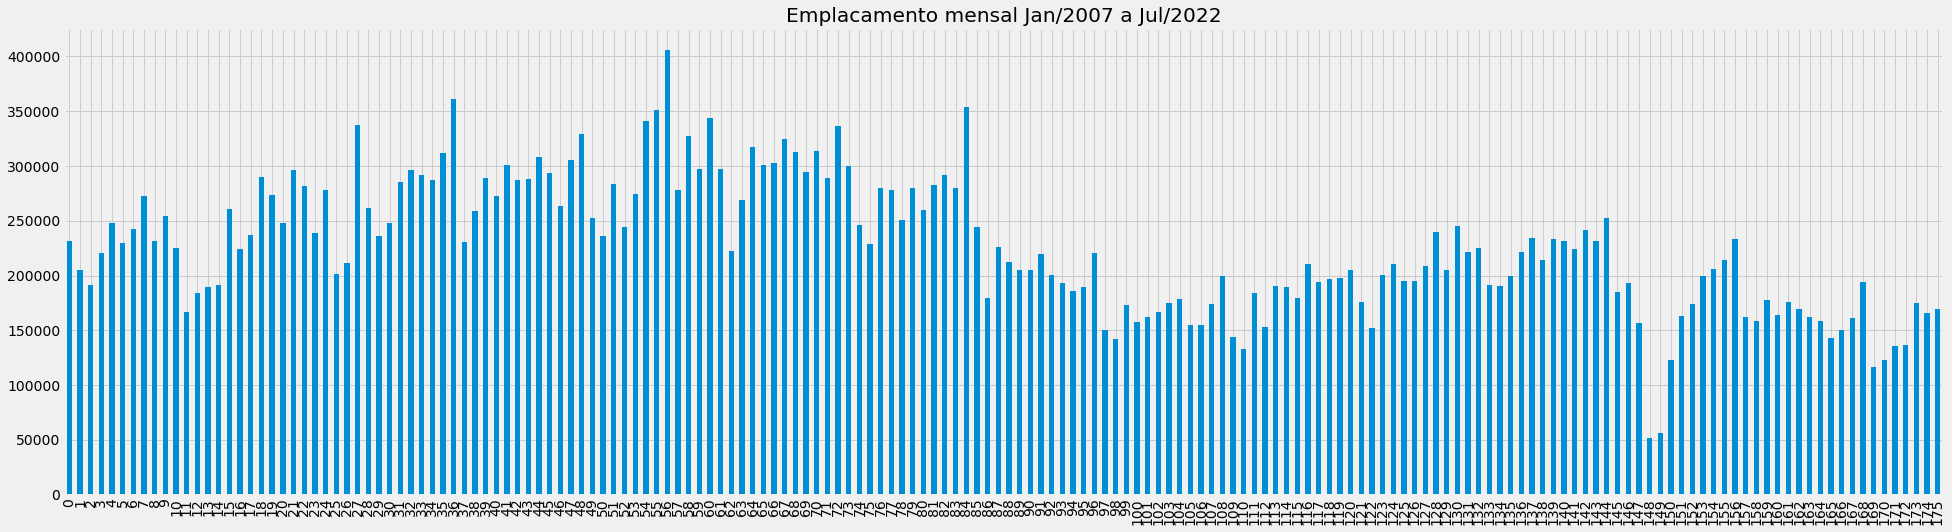

In [5]:
#criando gráfico de barras para visualizar os emplacamentos ao longo do período
plt.title('Emplacamento mensal Jan/2007 a Jul/2022')
df['Emplacamentos'].plot.bar(figsize=(30, 8))

In [6]:
#A fim de excluir fatores que impactaram na sazonalidade do mercado automotivo vou desconsiderar 2 últimos principais fatores:
# abr/2019 ~ -> crise Argentina 
# mar/2020 covid 19 
#Definindo a coluna de data como index
df.set_index('Date', inplace=True)
df =df['2007-01-01' :'2019-12-01']
df.describe

<bound method NDFrame.describe of             Emplacamentos
Date                     
2007-12-01         231174
2008-01-01         205384
2008-02-01         191155
2008-03-01         220884
2008-04-01         247938
...                   ...
2019-08-01         231522
2019-09-01         224014
2019-10-01         241786
2019-11-01         231590
2019-12-01         252037

[145 rows x 1 columns]>

<AxesSubplot:xlabel='Date'>

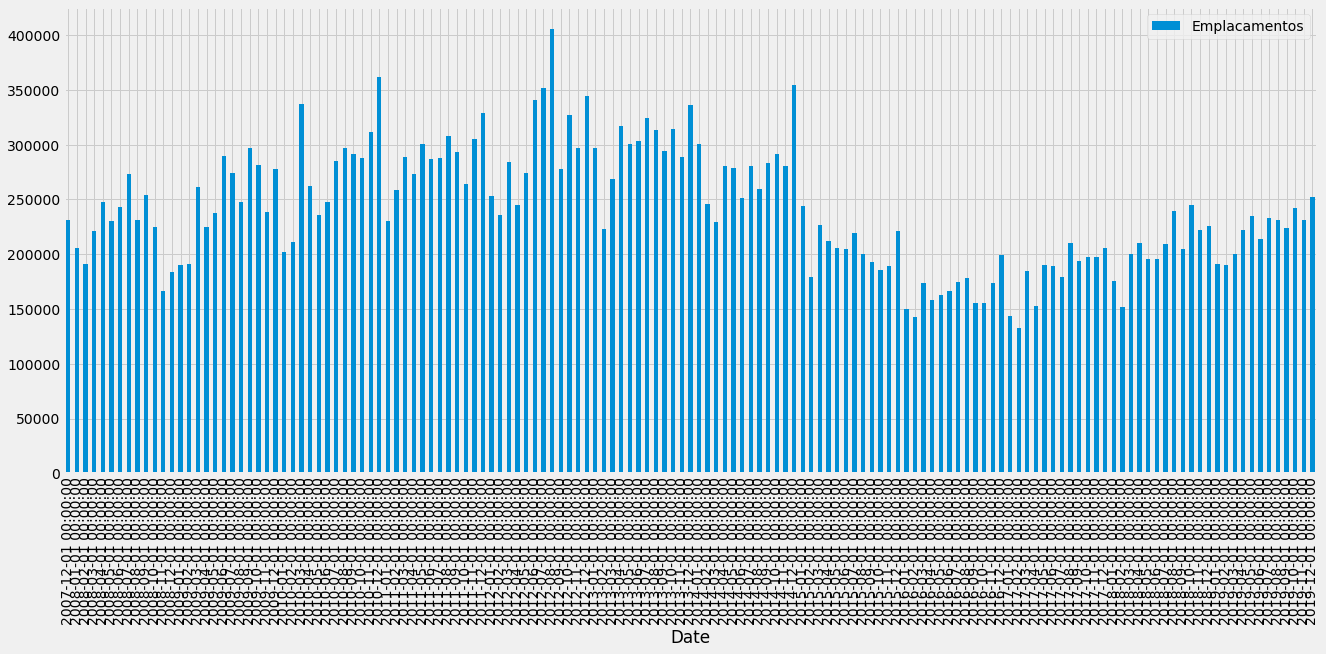

In [7]:
df.plot.bar(figsize=(20, 8))

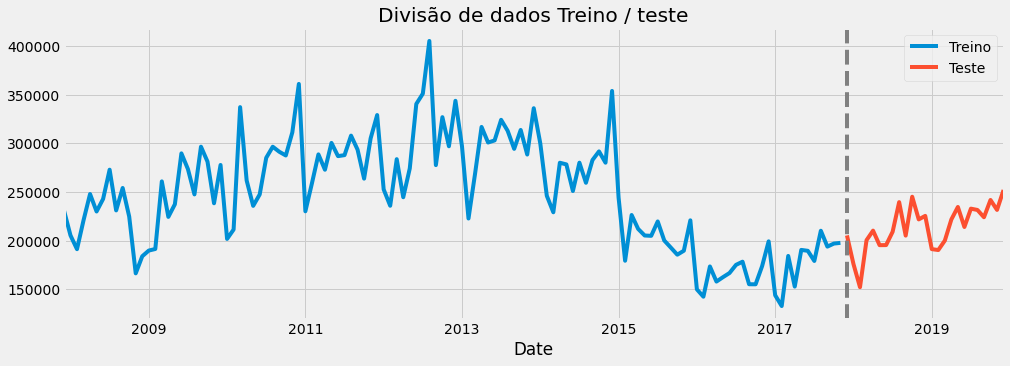

In [8]:
train = df.loc[df.index < '2017-12-01']
test = df.loc[df.index >= '2017-12-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Treino', title='Divisão de dados Treino / teste')
test.plot(ax=ax, label='Teste')
ax.axvline('2017-12-01', color='gray', ls='--')
ax.legend(['Treino', 'Teste'])
plt.show()

In [9]:
df.index = pd.to_datetime(df.index)

#### Adicionando colunas de data para alimentar o modelo

In [10]:
def create_features(df):
    df = df.copy()
    df['trimestre'] = df.index.quarter
    df['mes'] = df.index.month
    return df
df = create_features(df)

#### Visualizando a relação entre as variáveis criadas

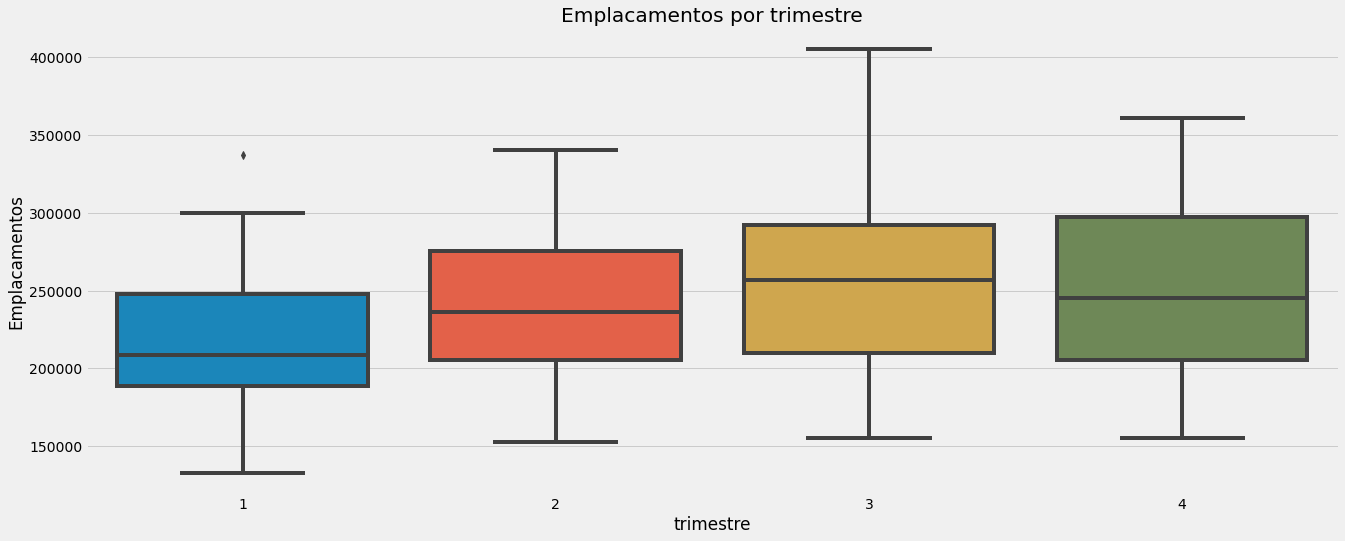

In [11]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.boxplot(data=df, x='trimestre', y='Emplacamentos')
ax.set_title('Emplacamentos por trimestre')
plt.show()

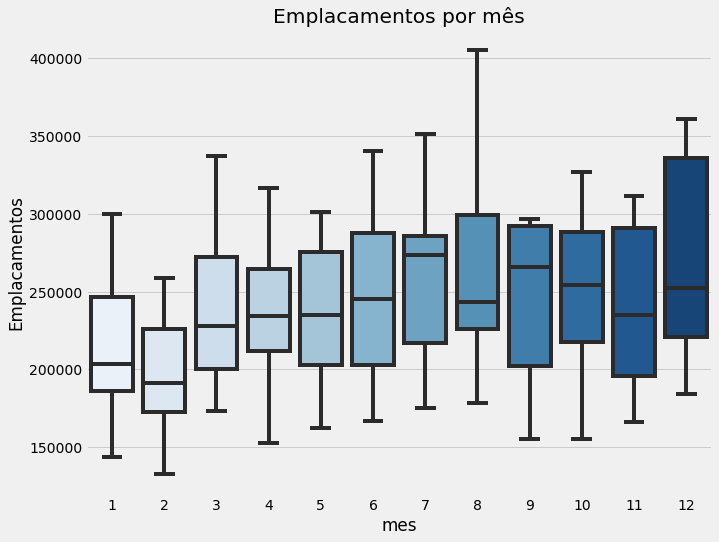

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='mes', y='Emplacamentos', palette='Blues')
ax.set_title('Emplacamentos por mês')
plt.show()

#### Criando o modelo

In [13]:
train = create_features(train)
test = create_features(test)

FEATURES = ['trimestre','mes'] #  ['trimestre', 'mes']
TARGET = 'Emplacamentos'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:251153.84041	validation_1-rmse:212647.84099
[100]	validation_0-rmse:106018.67728	validation_1-rmse:60000.84908
[200]	validation_0-rmse:63562.91472	validation_1-rmse:15821.24079
[250]	validation_0-rmse:57332.63150	validation_1-rmse:20718.91664


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

#### Visualizando o peso de cada variável

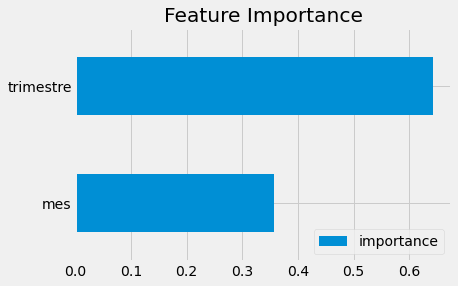

In [15]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#### Testando o modelo

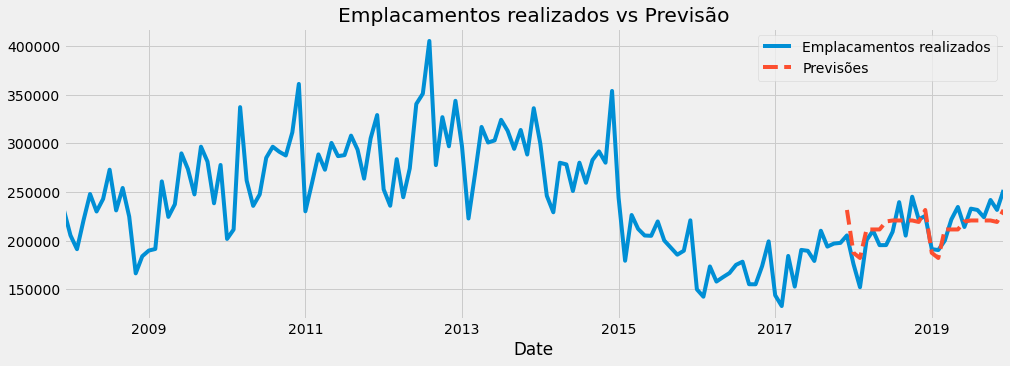

In [16]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Emplacamentos']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='--')
plt.legend(['Emplacamentos realizados', 'Previsões'])
ax.set_title('Emplacamentos realizados vs Previsão')
plt.show()

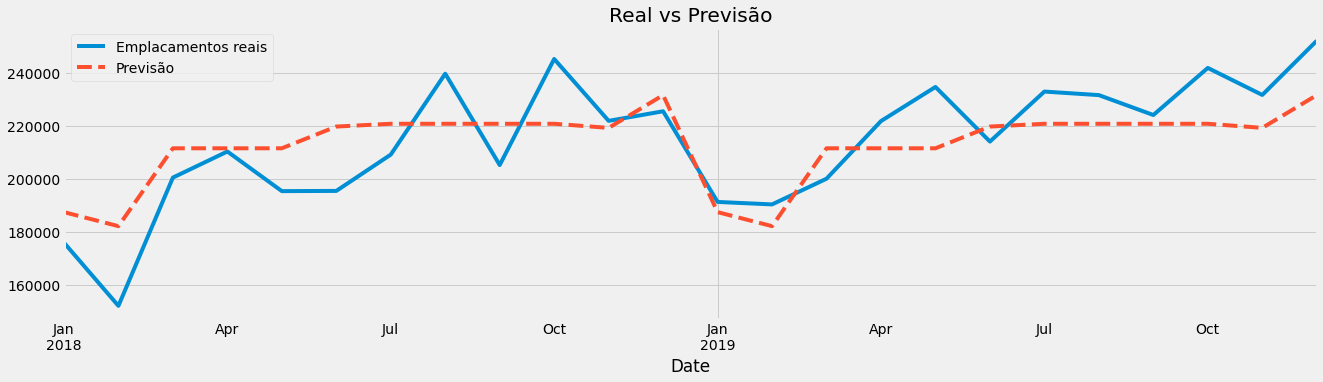

In [17]:
#Visualizando ano de 2018 mês a mês
ax = df.loc[(df.index > '12-01-2017') & (df.index < '31-12-2019')]['Emplacamentos'] \
    .plot(figsize=(20, 5), title='Real vs Previsão')
df.loc[(df.index > '12-01-2017') & (df.index < '31-12-2019')]['prediction'] \
    .plot(style='--')
plt.legend(['Emplacamentos reais','Previsão'])
plt.show()

#### Calculando o score do modelo

In [18]:
score = np.sqrt(mean_squared_error(test['Emplacamentos'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 15821.24


In [19]:
#visualizando os meses onde o modelo mais ERROU
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-02-01    30077.718750
2017-12-01    26190.062500
2018-10-01    24454.968750
2018-06-01    24284.953125
2019-05-01    23145.578125
2019-10-01    21081.968750
2019-12-01    20528.937500
2018-08-01    18893.968750
2018-05-01    16162.421875
2018-09-01    15571.031250
Name: error, dtype: float64

In [20]:
#visualizando os meses onde o modelo mais ACERTOU
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(20)

date
2018-04-01     1215.421875
2018-11-01     2650.687500
2019-09-01     3309.968750
2019-01-01     3848.125000
2019-06-01     5658.953125
2018-12-01     6084.062500
2019-02-01     8201.281250
2019-04-01    10269.578125
2019-08-01    10817.968750
2018-03-01    11060.421875
2019-03-01    11479.421875
2018-01-01    11503.875000
2018-07-01    11630.031250
2019-07-01    12156.968750
2019-11-01    12432.687500
2018-09-01    15571.031250
2018-05-01    16162.421875
2018-08-01    18893.968750
2019-12-01    20528.937500
2019-10-01    21081.968750
Name: error, dtype: float64